<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/CPW_Heatmap_with_CuPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [19]:
# @title GPU & environment setup (CuPy + gdstk + matplotlib)
# @markdown This cell:
# @markdown - Checks that a GPU is visible in Colab
# @markdown - Installs CuPy for CUDA 12 (compatible with L4)
# @markdown - Installs gdstk (for future GDSII use) and matplotlib

import subprocess
import textwrap
import sys

plt.rcParams['figure.dpi'] = 200

def run(cmd):
    """Run a shell command and stream output."""
    print(f"$ {' '.join(cmd)}")
    subprocess.run(cmd, check=True)

# Check GPU
print("=== nvidia-smi ===")
try:
    run(["nvidia-smi"])
except Exception as exc:  # pylint: disable=broad-except
    print("GPU not visible. Please enable GPU in Colab runtime.")
    print(exc)

# Install required packages
print("\n=== Installing Python packages ===")
run([sys.executable, "-m", "pip", "install", "-q", "cupy-cuda12x", "gdstk", "matplotlib"])

print("\nEnvironment setup complete.")


=== nvidia-smi ===
$ nvidia-smi

=== Installing Python packages ===
$ /usr/bin/python3 -m pip install -q cupy-cuda12x gdstk matplotlib

Environment setup complete.


In [2]:
# @title Simulation configuration (control knobs)
# @markdown Adjust these parameters to change geometry, materials, and solver settings.

from __future__ import annotations

from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import cupy as cp


@dataclass
class SimulationConfig:
    """Configuration parameters for CPW quasi-static GPU simulation.

    Attributes:
        dx_um: Grid spacing in micrometers.
        width_um: Width of center conductor in micrometers.
        gap_um: Gap between center conductor edge and ground in micrometers.
        ground_span_um: Half-span of ground plane region from CPW center (x-direction).
        substrate_thickness_um: Substrate thickness (y < 0) in micrometers.
        air_height_um: Air height above metal (y > 0) in micrometers.
        eps_r_substrate: Relative permittivity of substrate.
        eps_r_air: Relative permittivity of air.
        max_iters: Maximum Jacobi iterations.
        tol: Convergence tolerance on maximum voltage change.
        verbose: If True, print convergence info periodically.
        resonator_lengths_um: List of CPW resonator lengths (micrometers).
    """

    dx_um: float = 0.25
    width_um: float = 10.0
    gap_um: float = 6.0
    ground_span_um: float = 80.0
    substrate_thickness_um: float = 500.0
    air_height_um: float = 500.0
    eps_r_substrate: float = 11.45  # e.g., sapphire ~ 9.4, silicon ~ 11.45
    eps_r_air: float = 1.0

    max_iters: int = 50_000
    tol: float = 1e-5
    verbose: bool = True

    resonator_lengths_um: Tuple[float, ...] = (10_000.0, 15_000.0, 20_000.0)


CFG = SimulationConfig()
CFG


SimulationConfig(dx_um=0.25, width_um=10.0, gap_um=6.0, ground_span_um=80.0, substrate_thickness_um=500.0, air_height_um=500.0, eps_r_substrate=11.45, eps_r_air=1.0, max_iters=50000, tol=1e-05, verbose=True, resonator_lengths_um=(10000.0, 15000.0, 20000.0))

In [3]:
# @title Geometry & material grid construction on GPU
# @markdown Creates 2D arrays for permittivity and conductor masks.

def build_cpw_geometry(cfg: SimulationConfig) -> Tuple[cp.ndarray, cp.ndarray, cp.ndarray, cp.ndarray, float, float]:
    """Create CPW geometry and material arrays on the GPU.

    Args:
        cfg: SimulationConfig instance.

    Returns:
        eps_r_gpu: Relative permittivity map on GPU.
        signal_mask: Boolean mask (GPU) for signal conductor.
        ground_mask: Boolean mask (GPU) for ground conductors.
        update_mask: Boolean mask (GPU) for nodes to update in Laplace solver.
        dx_m: Grid spacing in meters.
        dy_m: Grid spacing in meters.
    """
    dx_m = cfg.dx_um * 1e-6
    dy_m = dx_m  # square grid

    x_max_um = cfg.ground_span_um
    y_bottom_um = -cfg.substrate_thickness_um
    y_top_um = cfg.air_height_um

    x_um = np.arange(-x_max_um, x_max_um + cfg.dx_um, cfg.dx_um)
    y_um = np.arange(y_bottom_um, y_top_um + cfg.dx_um, cfg.dx_um)

    nx = x_um.size
    ny = y_um.size

    print(f"Grid size: nx={nx}, ny={ny}, total nodes={nx * ny}")

    # Broadcast coordinate grids
    x_grid_um, y_grid_um = np.meshgrid(x_um, y_um, indexing="xy")

    # Material map (numpy first)
    eps_r_np = np.where(
        y_grid_um < 0.0,  # below metal plane = substrate
        cfg.eps_r_substrate,
        cfg.eps_r_air,
    )

    # Signal conductor: centered at x=0, occupying y=0 plane (approx as stripe of one cell tall)
    half_w = cfg.width_um / 2.0
    signal_region = (
        (y_grid_um >= -0.5 * cfg.dx_um)
        & (y_grid_um <= 0.5 * cfg.dx_um)
        & (x_grid_um >= -half_w)
        & (x_grid_um <= half_w)
    )

    # Ground conductors: left and right of the gap on same y-range as signal
    left_ground = (
        (y_grid_um >= -0.5 * cfg.dx_um)
        & (y_grid_um <= 0.5 * cfg.dx_um)
        & (x_grid_um <= -(half_w + cfg.gap_um))
    )
    right_ground = (
        (y_grid_um >= -0.5 * cfg.dx_um)
        & (y_grid_um <= 0.5 * cfg.dx_um)
        & (x_grid_um >= +(half_w + cfg.gap_um))
    )
    ground_region = left_ground | right_ground

    # Convert to GPU arrays
    eps_r_gpu = cp.asarray(eps_r_np, dtype=cp.float64)
    signal_mask = cp.asarray(signal_region, dtype=cp.bool_)
    ground_mask = cp.asarray(ground_region, dtype=cp.bool_)

    # Nodes to update (not conductors)
    fixed_mask = signal_mask | ground_mask
    update_mask = ~fixed_mask

    return eps_r_gpu, signal_mask, ground_mask, update_mask, dx_m, dy_m


eps_r_gpu, signal_mask_gpu, ground_mask_gpu, update_mask_gpu, DX_M, DY_M = build_cpw_geometry(CFG)


Grid size: nx=641, ny=4001, total nodes=2564641


In [4]:
# @title GPU Laplace solver (Jacobi iteration)
# @markdown Solves ∇²V = 0 with fixed potentials on conductors using CuPy arrays.

def solve_laplace_gpu(
    eps_r: cp.ndarray,
    signal_mask: cp.ndarray,
    ground_mask: cp.ndarray,
    update_mask: cp.ndarray,
    cfg: SimulationConfig,
) -> cp.ndarray:
    """Solve Laplace's equation on a 2D grid using Jacobi iteration on GPU.

    Args:
        eps_r: Relative permittivity map (ignored in pure Laplace update, but kept for future use).
        signal_mask: Boolean mask for signal conductor.
        ground_mask: Boolean mask for ground conductors.
        update_mask: Boolean mask for nodes to update.
        cfg: SimulationConfig.

    Returns:
        v: Potential array on GPU.
    """
    ny, nx = eps_r.shape

    v = cp.zeros((ny, nx), dtype=cp.float64)

    # Set conductor potentials: +/- 0.5 V for a total difference of 1 V
    v = cp.where(signal_mask, 0.5, v)
    v = cp.where(ground_mask, -0.5, v)

    # Pre-compute masks
    interior_mask = update_mask.copy()

    # Exclude outer boundary from updates (Dirichlet 0 at edges)
    interior_mask[0, :] = False
    interior_mask[-1, :] = False
    interior_mask[:, 0] = False
    interior_mask[:, -1] = False

    if cfg.verbose:
        print("Starting Jacobi iterations on GPU...")

    for it in range(cfg.max_iters):
        v_old = v.copy()

        # Shifted versions for neighbor averaging
        v_up = cp.roll(v_old, -1, axis=0)
        v_down = cp.roll(v_old, +1, axis=0)
        v_left = cp.roll(v_old, -1, axis=1)
        v_right = cp.roll(v_old, +1, axis=1)

        v_new = (v_up + v_down + v_left + v_right) * 0.25

        # Enforce conductors
        v_new = cp.where(signal_mask, 0.5, v_new)
        v_new = cp.where(ground_mask, -0.5, v_new)

        # Enforce outer boundary Dirichlet 0 (for simplicity)
        v_new[0, :] = 0.0
        v_new[-1, :] = 0.0
        v_new[:, 0] = 0.0
        v_new[:, -1] = 0.0

        # Only update interior nodes; others remain as set
        v = cp.where(interior_mask, v_new, v)

        # Convergence check
        diff = cp.max(cp.abs(v - v_old))
        if cfg.verbose and (it % 500 == 0):
            print(f"Iteration {it}: max ΔV = {float(diff):.3e}")
        if diff < cfg.tol:
            if cfg.verbose:
                print(f"Converged at iteration {it} with max ΔV = {float(diff):.3e}")
            break
    else:
        print("Warning: did not converge within max_iters.")

    return v


V_gpu = solve_laplace_gpu(
    eps_r_gpu, signal_mask_gpu, ground_mask_gpu, update_mask_gpu, CFG
)


Starting Jacobi iterations on GPU...
Iteration 0: max ΔV = 1.250e-01
Iteration 500: max ΔV = 2.415e-04
Iteration 1000: max ΔV = 1.208e-04
Iteration 1500: max ΔV = 8.059e-05
Iteration 2000: max ΔV = 6.046e-05
Iteration 2500: max ΔV = 4.837e-05
Iteration 3000: max ΔV = 4.030e-05
Iteration 3500: max ΔV = 3.452e-05
Iteration 4000: max ΔV = 3.016e-05
Iteration 4500: max ΔV = 2.674e-05
Iteration 5000: max ΔV = 2.400e-05
Iteration 5500: max ΔV = 2.172e-05
Iteration 6000: max ΔV = 1.981e-05
Iteration 6500: max ΔV = 1.818e-05
Iteration 7000: max ΔV = 1.677e-05
Iteration 7500: max ΔV = 1.553e-05
Iteration 8000: max ΔV = 1.444e-05
Iteration 8500: max ΔV = 1.347e-05
Iteration 9000: max ΔV = 1.261e-05
Iteration 9500: max ΔV = 1.183e-05
Iteration 10000: max ΔV = 1.113e-05
Iteration 10500: max ΔV = 1.049e-05
Converged at iteration 10916 with max ΔV = 1.000e-05


In [5]:
# @title Capacitance extraction from GPU potential
# @markdown Computes C' from stored electric energy per unit length using ε|E|².

EPS_0 = 8.8541878128e-12  # F/m
C_LIGHT = 299_792_458.0   # m/s


def compute_capacitance_per_length(
    v: cp.ndarray,
    eps_r: cp.ndarray,
    dx_m: float,
    dy_m: float,
) -> float:
    """Compute capacitance per unit length (F/m) from potential and permittivity.

    Uses U' = 0.5 ∫ ε |E|^2 dA and C' = 2U' / V^2 for a 1 V potential difference.

    Args:
        v: Potential array on GPU.
        eps_r: Relative permittivity map on GPU.
        dx_m: Grid spacing in x (meters).
        dy_m: Grid spacing in y (meters).

    Returns:
        c_prime: Capacitance per unit length in F/m.
    """
    # Central differences (internal nodes only), padded with zeros at edges
    dv_dx = (cp.roll(v, -1, axis=1) - cp.roll(v, +1, axis=1)) / (2.0 * dx_m)
    dv_dy = (cp.roll(v, -1, axis=0) - cp.roll(v, +1, axis=0)) / (2.0 * dy_m)

    ex = -dv_dx
    ey = -dv_dy

    eps = EPS_0 * eps_r
    energy_density = 0.5 * eps * (ex**2 + ey**2)

    dA = dx_m * dy_m
    u_per_length = cp.sum(energy_density) * dA  # J per meter (since this is per unit length)

    # Potential difference between signal and ground is 1 V by construction
    c_prime = 2.0 * float(u_per_length)  # F/m

    return c_prime


C_prime = compute_capacitance_per_length(V_gpu, eps_r_gpu, DX_M, DY_M)
print(f"C' (with substrate) = {C_prime:.3e} F/m")


C' (with substrate) = 3.747e-10 F/m


In [6]:
# @title Effective permittivity and Z0 computation
# @markdown Re-solve with ε_r = 1 to get ε_eff and Z0.

def recompute_in_air(
    signal_mask: cp.ndarray,
    ground_mask: cp.ndarray,
    update_mask: cp.ndarray,
    cfg: SimulationConfig,
) -> float:
    """Re-run Laplace solver with ε_r = 1 everywhere to get C'_a."""
    # ε_r = 1 everywhere -> copy shape
    eps_r_air = cp.ones_like(signal_mask, dtype=cp.float64)

    v_air = solve_laplace_gpu(
        eps_r_air, signal_mask, ground_mask, update_mask, cfg
    )
    c_prime_air = compute_capacitance_per_length(v_air, eps_r_air, DX_M, DY_M)
    return c_prime_air


C_prime_air = recompute_in_air(
    signal_mask_gpu, ground_mask_gpu, update_mask_gpu, CFG
)
print(f"C'_air (ε_r=1) = {C_prime_air:.3e} F/m")

eps_eff = C_prime / C_prime_air
v_phase = C_LIGHT / np.sqrt(eps_eff)
Z0 = 1.0 / (C_prime * v_phase)

print(f"ε_eff = {eps_eff:.3f}")
print(f"Phase velocity v_p = {v_phase:.3e} m/s")
print(f"Characteristic impedance Z0 ≈ {Z0:.2f} Ω")


Starting Jacobi iterations on GPU...
Iteration 0: max ΔV = 1.250e-01
Iteration 500: max ΔV = 2.415e-04
Iteration 1000: max ΔV = 1.208e-04
Iteration 1500: max ΔV = 8.059e-05
Iteration 2000: max ΔV = 6.046e-05
Iteration 2500: max ΔV = 4.837e-05
Iteration 3000: max ΔV = 4.030e-05
Iteration 3500: max ΔV = 3.452e-05
Iteration 4000: max ΔV = 3.016e-05
Iteration 4500: max ΔV = 2.674e-05
Iteration 5000: max ΔV = 2.400e-05
Iteration 5500: max ΔV = 2.172e-05
Iteration 6000: max ΔV = 1.981e-05
Iteration 6500: max ΔV = 1.818e-05
Iteration 7000: max ΔV = 1.677e-05
Iteration 7500: max ΔV = 1.553e-05
Iteration 8000: max ΔV = 1.444e-05
Iteration 8500: max ΔV = 1.347e-05
Iteration 9000: max ΔV = 1.261e-05
Iteration 9500: max ΔV = 1.183e-05
Iteration 10000: max ΔV = 1.113e-05
Iteration 10500: max ΔV = 1.049e-05
Converged at iteration 10916 with max ΔV = 1.000e-05
C'_air (ε_r=1) = 6.090e-11 F/m
ε_eff = 6.153
Phase velocity v_p = 1.209e+08 m/s
Characteristic impedance Z0 ≈ 22.08 Ω


In [7]:
# @title CPW resonant frequencies from ε_eff and v_p
# @markdown Computes λ/4 and λ/2 fundamental frequencies for user-provided lengths.

def compute_resonant_frequencies(
    lengths_um: Tuple[float, ...],
    v_phase_m_per_s: float,
) -> List[Tuple[float, float, float]]:
    """Compute fundamental λ/4 and λ/2 frequencies for each length.

    Args:
        lengths_um: Tuple of resonator lengths in micrometers.
        v_phase_m_per_s: Phase velocity in m/s.

    Returns:
        List of tuples (length_um, f_quarter_Hz, f_half_Hz).
    """
    results = []
    for length_um in lengths_um:
        length_m = length_um * 1e-6
        f_quarter = v_phase_m_per_s / (4.0 * length_m)
        f_half = v_phase_m_per_s / (2.0 * length_m)
        results.append((length_um, f_quarter, f_half))
    return results


resonance_data = compute_resonant_frequencies(CFG.resonator_lengths_um, v_phase)

# Display as a table
print("Resonant frequencies:")
print("length [µm]   f_λ/4 [GHz]   f_λ/2 [GHz]")
for length_um, f_q, f_h in resonance_data:
    print(f"{length_um:10.1f}   {f_q / 1e9:10.3f}   {f_h / 1e9:10.3f}")


Resonant frequencies:
length [µm]   f_λ/4 [GHz]   f_λ/2 [GHz]
   10000.0        3.021        6.043
   15000.0        2.014        4.029
   20000.0        1.511        3.021


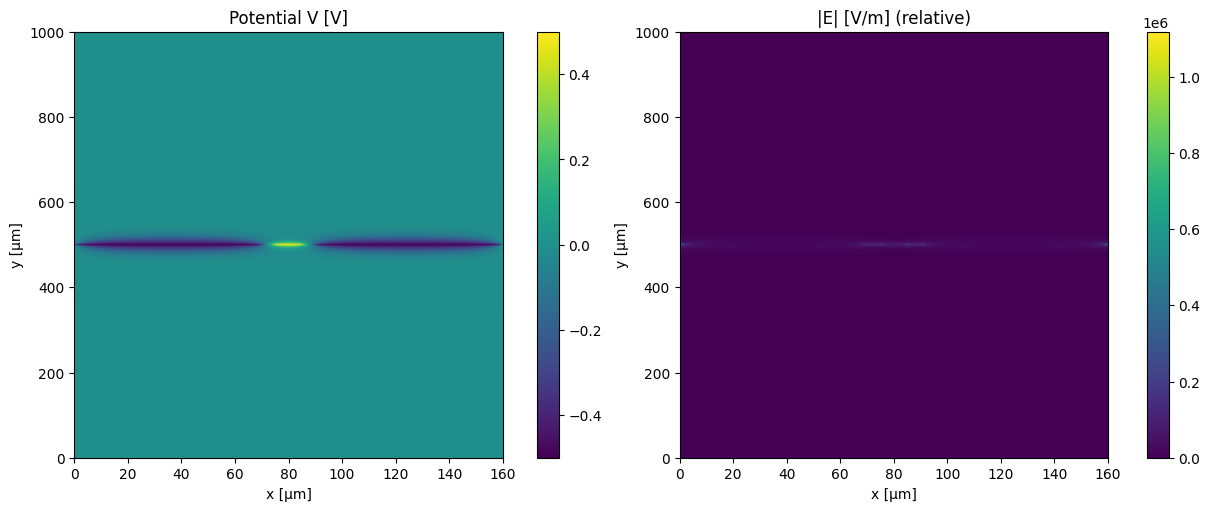

In [8]:
# @title Plot potential and electric field magnitude
# @markdown Visualizes V(x, y) and |E| as 2D colormaps.

import matplotlib.pyplot as plt


def plot_potential_and_field(
    v_gpu: cp.ndarray,
    eps_r_gpu: cp.ndarray,
    dx_m: float,
    dy_m: float,
) -> None:
    """Plot potential and electric field magnitude."""
    v = cp.asnumpy(v_gpu)
    eps_r = cp.asnumpy(eps_r_gpu)

    ny, nx = v.shape
    x = np.arange(nx) * dx_m
    y = np.arange(ny) * dy_m

    # Compute field on CPU for plotting
    dv_dx = (np.roll(v, -1, axis=1) - np.roll(v, +1, axis=1)) / (2.0 * dx_m)
    dv_dy = (np.roll(v, -1, axis=0) - np.roll(v, +1, axis=0)) / (2.0 * dy_m)
    e_mag = np.sqrt(dv_dx**2 + dv_dy**2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    im0 = axes[0].imshow(
        v,
        extent=[x[0] * 1e6, x[-1] * 1e6, y[0] * 1e6, y[-1] * 1e6],
        origin="lower",
        aspect="auto",
    )
    axes[0].set_title("Potential V [V]")
    axes[0].set_xlabel("x [µm]")
    axes[0].set_ylabel("y [µm]")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(
        e_mag,
        extent=[x[0] * 1e6, x[-1] * 1e6, y[0] * 1e6, y[-1] * 1e6],
        origin="lower",
        aspect="auto",
    )
    axes[1].set_title("|E| [V/m] (relative)")
    axes[1].set_xlabel("x [µm]")
    axes[1].set_ylabel("y [µm]")
    fig.colorbar(im1, ax=axes[1])

    plt.show()


plot_potential_and_field(V_gpu, eps_r_gpu, DX_M, DY_M)


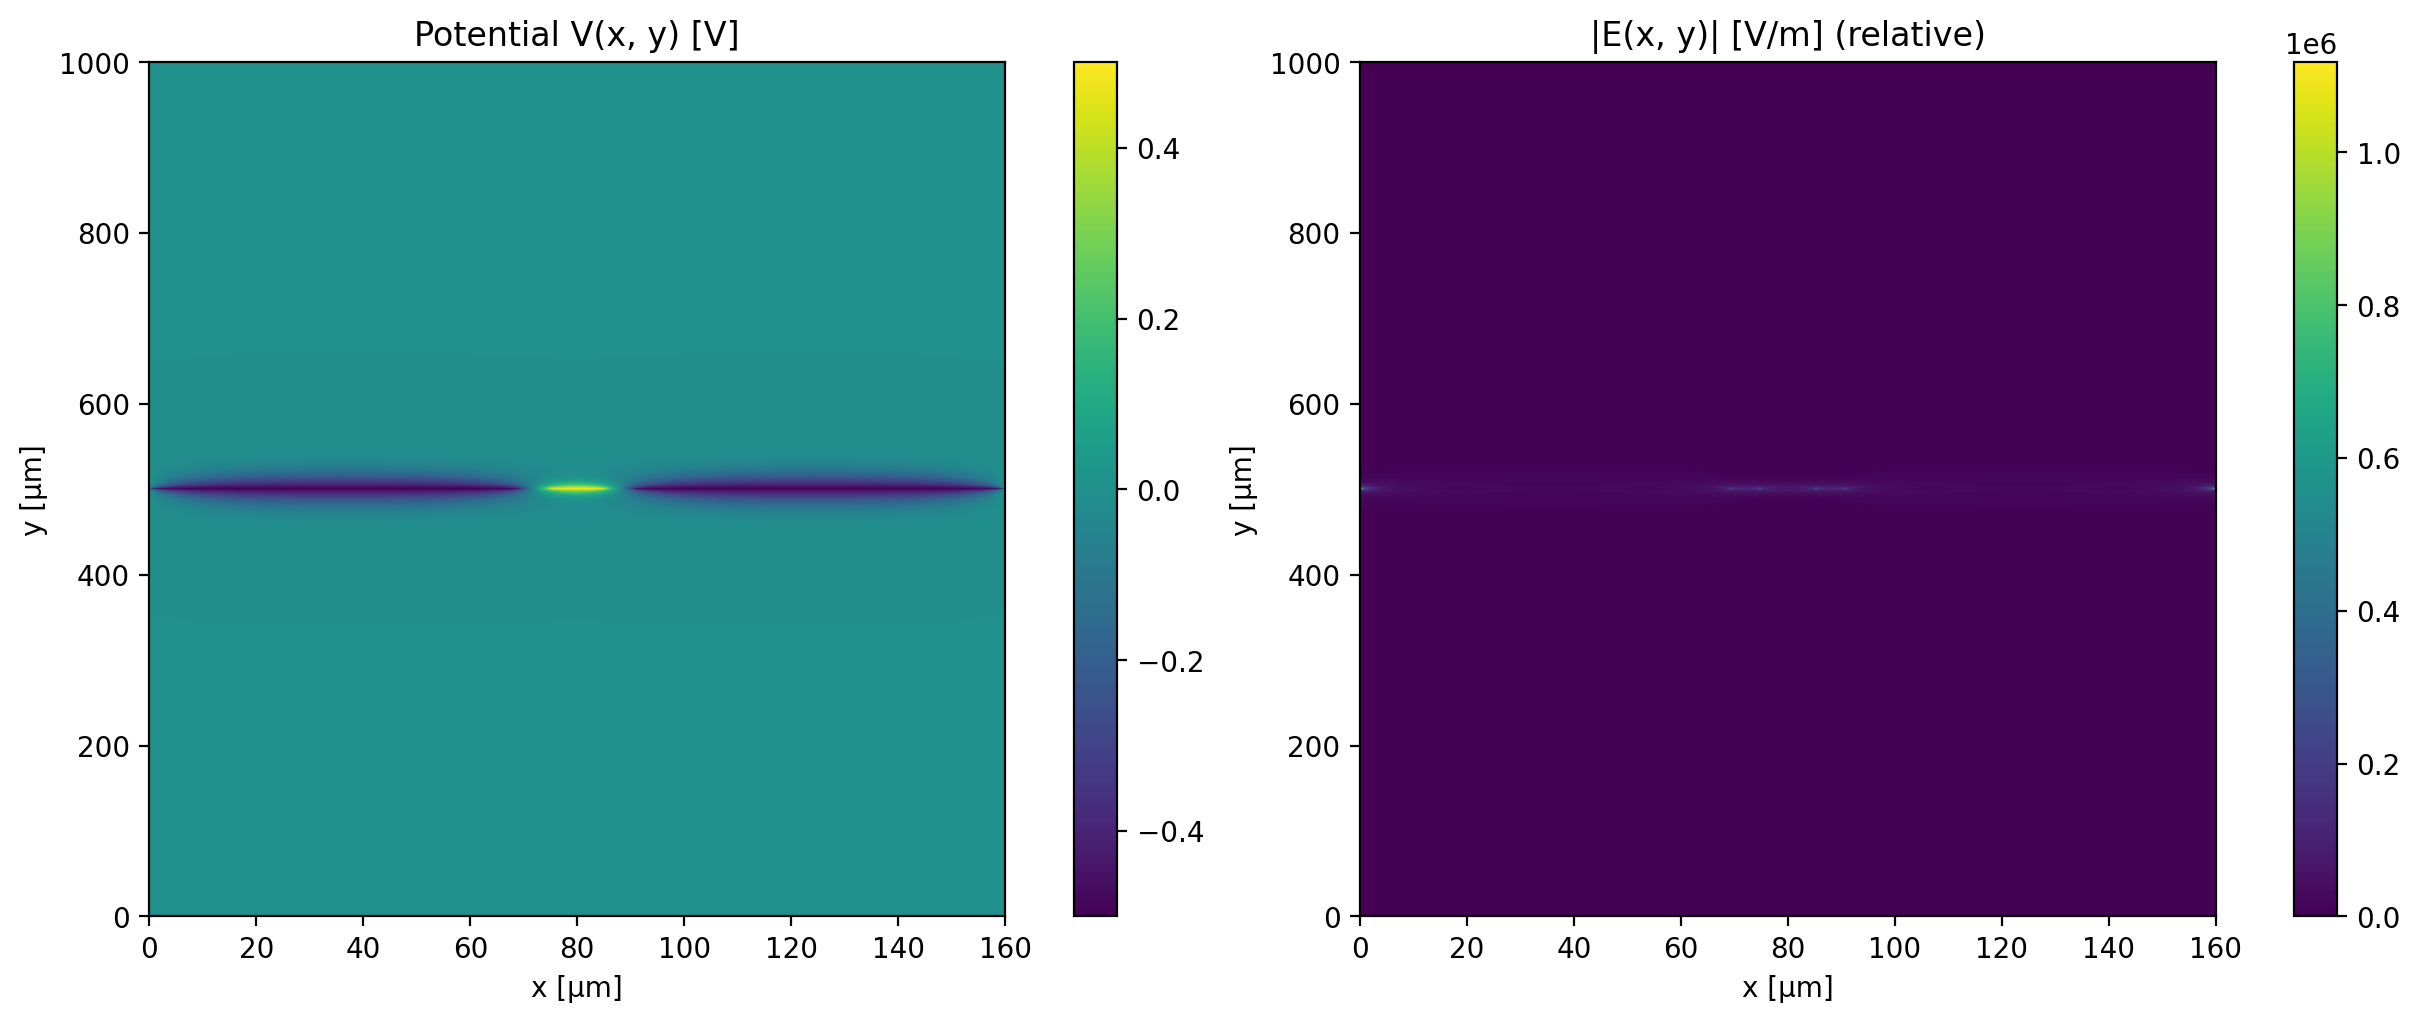

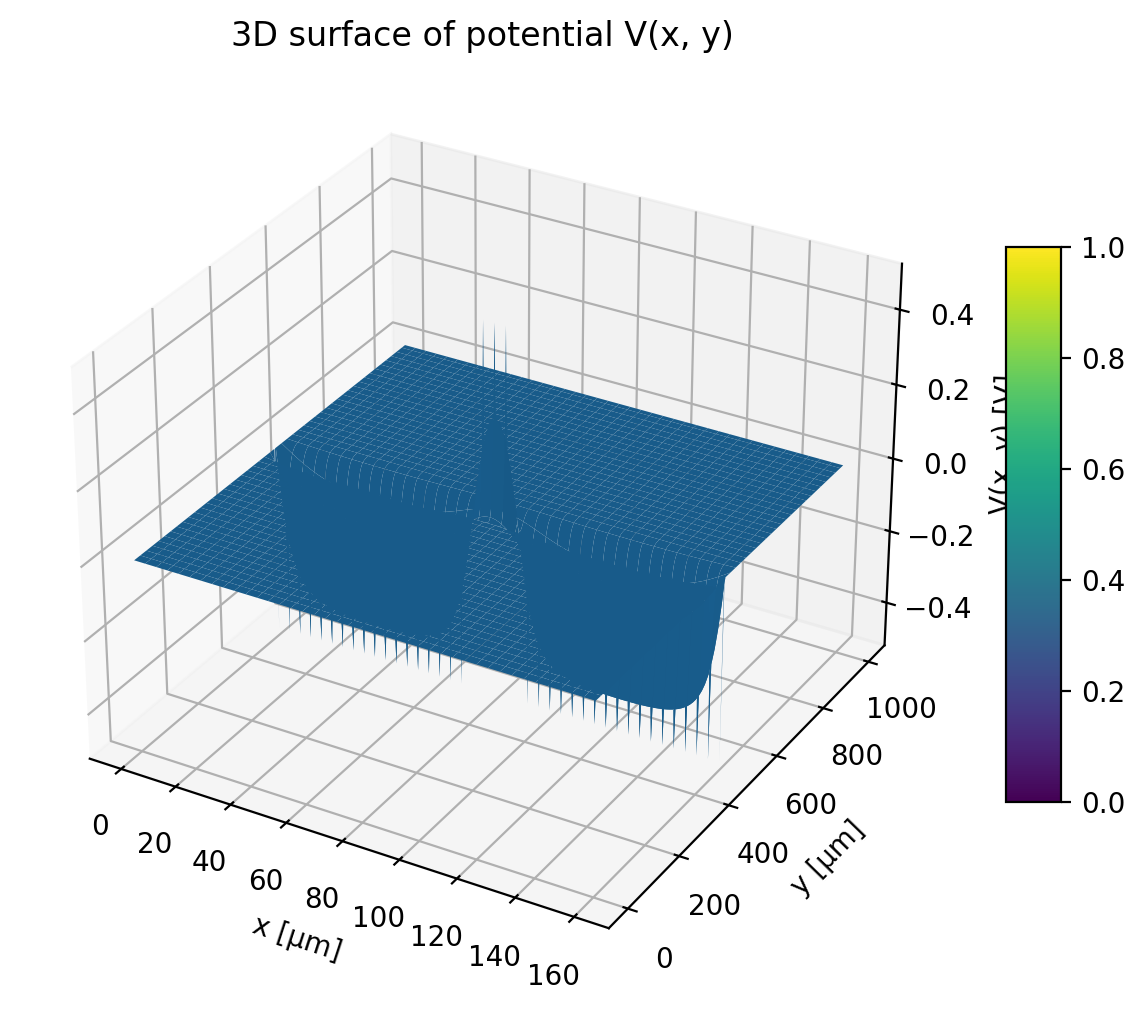

In [23]:
# @title Plot potential and electric field: 2D & 3D heat maps
# @markdown This cell:
# @markdown - Plots 2D heat maps (V and |E|)
# @markdown - Optionally plots a 3D surface "heat map" of V or |E|
# @markdown Use the `plot_3d` and `plot_quantity` knobs to control the 3D view.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D projection)


def plot_potential_and_field(
    v_gpu: cp.ndarray,
    eps_r_gpu: cp.ndarray,
    dx_m: float,
    dy_m: float,
    plot_3d: bool = True,
    plot_quantity: str = "V",  # "V" or "E"
    downsample: int = 3,
) -> None:
    """Plot potential and electric field magnitude.

    Args:
        v_gpu: Potential array on GPU.
        eps_r_gpu: Relative permittivity map on GPU (unused in plotting, kept for completeness).
        dx_m: Grid spacing (x-direction) in meters.
        dy_m: Grid spacing (y-direction) in meters.
        plot_3d: If True, also show a 3D surface "heat map".
        plot_quantity: Which quantity to use for the 3D surface ("V" or "E").
        downsample: Integer factor to downsample grid for 3D plotting (to keep it fast).
    """
    # Move data back to CPU
    v = cp.asnumpy(v_gpu)
    eps_r = cp.asnumpy(eps_r_gpu)  # noqa: F841  (not used yet, but available)

    ny, nx = v.shape
    x = np.arange(nx) * dx_m
    y = np.arange(ny) * dy_m

    # Compute field on CPU for plotting
    dv_dx = (np.roll(v, -1, axis=1) - np.roll(v, +1, axis=1)) / (2.0 * dx_m)
    dv_dy = (np.roll(v, -1, axis=0) - np.roll(v, +1, axis=0)) / (2.0 * dy_m)
    e_mag = np.sqrt(dv_dx**2 + dv_dy**2)

    # --- 2D heat maps: V and |E| ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    im0 = axes[0].imshow(
        v,
        extent=[x[0] * 1e6, x[-1] * 1e6, y[0] * 1e6, y[-1] * 1e6],
        origin="lower",
        aspect="auto",
    )
    axes[0].set_title("Potential V(x, y) [V]")
    axes[0].set_xlabel("x [µm]")
    axes[0].set_ylabel("y [µm]")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(
        e_mag,
        extent=[x[0] * 1e6, x[-1] * 1e6, y[0] * 1e6, y[-1] * 1e6],
        origin="lower",
        aspect="auto",
    )
    axes[1].set_title("|E(x, y)| [V/m] (relative)")
    axes[1].set_xlabel("x [µm]")
    axes[1].set_ylabel("y [µm]")
    fig.colorbar(im1, ax=axes[1])

    plt.show()

    # --- Optional 3D surface "heat map" ---
    if not plot_3d:
        return

    if plot_quantity.upper() == "V":
        z_data = v
        label = "V(x, y) [V]"
        title = "3D surface of potential V(x, y)"
    else:
        z_data = e_mag
        label = "|E(x, y)| [V/m] (relative)"
        title = "3D surface of |E(x, y)|"

    # Downsample for faster 3D plotting
    z_ds = z_data[::downsample, ::downsample]
    x_ds = x[::downsample] * 1e6  # meters → micrometers
    y_ds = y[::downsample] * 1e6

    X_ds, Y_ds = np.meshgrid(x_ds, y_ds, indexing="xy")

    fig3d = plt.figure(figsize=(8, 6))
    ax3d = fig3d.add_subplot(111, projection="3d")

    surf = ax3d.plot_surface(
        X_ds,
        Y_ds,
        z_ds,
        linewidth=0.0,
        antialiased=True,
    )
    ax3d.set_title(title)
    ax3d.set_xlabel("x [µm]")
    ax3d.set_ylabel("y [µm]")
    ax3d.set_zlabel(label)
    fig3d.colorbar(surf, shrink=0.6, aspect=10)

    plt.show()


# Example usage: 2D heat maps + 3D surface of V
plot_potential_and_field(
    V_gpu,
    eps_r_gpu,
    DX_M,
    DY_M,
    plot_3d=True,
    plot_quantity="V",
    downsample=4,  # increase for faster plotting, decrease for more detail
)

In [10]:
# @title Longitudinal / resonator-mode configuration
# @markdown Additional knobs for modeling the field along the CPW resonator length.

from dataclasses import replace

@dataclass
class ModeConfig:
    """Configuration for standing-wave pattern along the CPW length.

    Attributes:
        length_um: Physical length of the CPW resonator (micrometers).
        n_z: Number of sampling points along the length.
        mode_type: 'lambda4' for λ/4, 'lambda2' for λ/2.
        mode_index: Mode index n (0 = fundamental for λ/4, 1 = first harmonic for λ/2).
    """
    length_um: float = 10_000.0  # 10 mm resonator
    n_z: int = 400
    mode_type: str = "lambda4"   # 'lambda4' or 'lambda2'
    mode_index: int = 0          # n = 0, 1, 2, ...


MODE = ModeConfig(length_um=10_000.0, n_z=400, mode_type="lambda4", mode_index=0)
MODE


ModeConfig(length_um=10000.0, n_z=400, mode_type='lambda4', mode_index=0)

In [11]:
# @title Extract 1D cross-section profile at CPW plane
# @markdown Takes the row closest to y = 0 as a lateral profile V_cs(x).

def extract_cross_section_profile(
    v_gpu: cp.ndarray,
    dx_m: float,
    dy_m: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """Extract 1D potential profile at the CPW metal plane (y≈0).

    Args:
        v_gpu: Potential array on GPU (ny, nx).
        dx_m: Grid spacing in x.
        dy_m: Grid spacing in y.

    Returns:
        x_um: 1D numpy array of x-coordinates [µm].
        v_profile_norm: 1D numpy array of normalized potential profile.
    """
    v = cp.asnumpy(v_gpu)
    ny, nx = v.shape

    # Choose the row index closest to y=0. For our construction, that is in the middle of the y-grid.
    # (You can adjust this if you change the geometry builder.)
    j_center = ny // 2

    v_profile = v[j_center, :]
    # Normalize so that max(|V|) = 1
    vmax = np.max(np.abs(v_profile))
    if vmax == 0:
        v_profile_norm = v_profile
    else:
        v_profile_norm = v_profile / vmax

    x = np.arange(nx) * dx_m  # meters
    x_um = x * 1e6

    print(f"Selected row index j_center={j_center} as CPW plane.")
    print(f"Profile max |V| before normalization: {vmax:.3e}")

    return x_um, v_profile_norm


x_um_profile, v_cs_norm = extract_cross_section_profile(V_gpu, DX_M, DY_M)


Selected row index j_center=2000 as CPW plane.
Profile max |V| before normalization: 5.000e-01


In [12]:
# @title Standing-wave envelope along the CPW length
# @markdown Computes normalized V_env(z) for λ/4 or λ/2 resonator.

def compute_longitudinal_envelope(mode_cfg: ModeConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Compute normalized standing-wave envelope V_env(z) along the CPW.

    Args:
        mode_cfg: ModeConfig specifying length, sampling, and mode type.

    Returns:
        z_um: 1D numpy array of z-coordinates [µm].
        v_env_norm: 1D numpy array of normalized envelope (max |V_env| = 1).
    """
    L_m = mode_cfg.length_um * 1e-6
    z = np.linspace(0.0, L_m, mode_cfg.n_z)
    z_um = z * 1e6

    if mode_cfg.mode_type.lower() == "lambda4":
        # λ/4 resonator; (2n+1)π/2L
        n = mode_cfg.mode_index
        k = (2 * n + 1) * np.pi / (2.0 * L_m)
        v_env = np.sin(k * z)
    else:
        # λ/2 resonator; mπ/L, where m = n+1
        m_idx = mode_cfg.mode_index + 1
        k = m_idx * np.pi / L_m
        v_env = np.sin(k * z)

    vmax = np.max(np.abs(v_env))
    if vmax == 0:
        v_env_norm = v_env
    else:
        v_env_norm = v_env / vmax

    print(
        f"Mode type: {mode_cfg.mode_type}, mode index: {mode_cfg.mode_index}, "
        f"k = {k:.3e} rad/m"
    )
    return z_um, v_env_norm


z_um, v_env_norm = compute_longitudinal_envelope(MODE)


Mode type: lambda4, mode index: 0, k = 1.571e+02 rad/m


In [13]:
# @title Build 2D top-down map V_top(x, z)
# @markdown Outer product of cross-section shape and longitudinal envelope.

def build_topdown_potential(
    x_um: np.ndarray,
    v_cs_norm: np.ndarray,
    z_um: np.ndarray,
    v_env_norm: np.ndarray,
) -> np.ndarray:
    """Construct a 2D potential map V_top(x, z) = V_cs_norm(x) * V_env_norm(z).

    Args:
        x_um: 1D array of lateral coordinates [µm].
        v_cs_norm: 1D normalized cross-section profile.
        z_um: 1D array of longitudinal coordinates [µm].
        v_env_norm: 1D normalized longitudinal envelope.

    Returns:
        V_top: 2D array of shape (len(z_um), len(x_um)).
    """
    # Shape: (n_z, n_x)
    V_top = np.outer(v_env_norm, v_cs_norm)
    return V_top


V_top = build_topdown_potential(
    x_um_profile, v_cs_norm, z_um, v_env_norm
)
print(f"V_top shape: {V_top.shape} (n_z, n_x) = ({V_top.shape[0]}, {V_top.shape[1]})")


V_top shape: (400, 641) (n_z, n_x) = (400, 641)


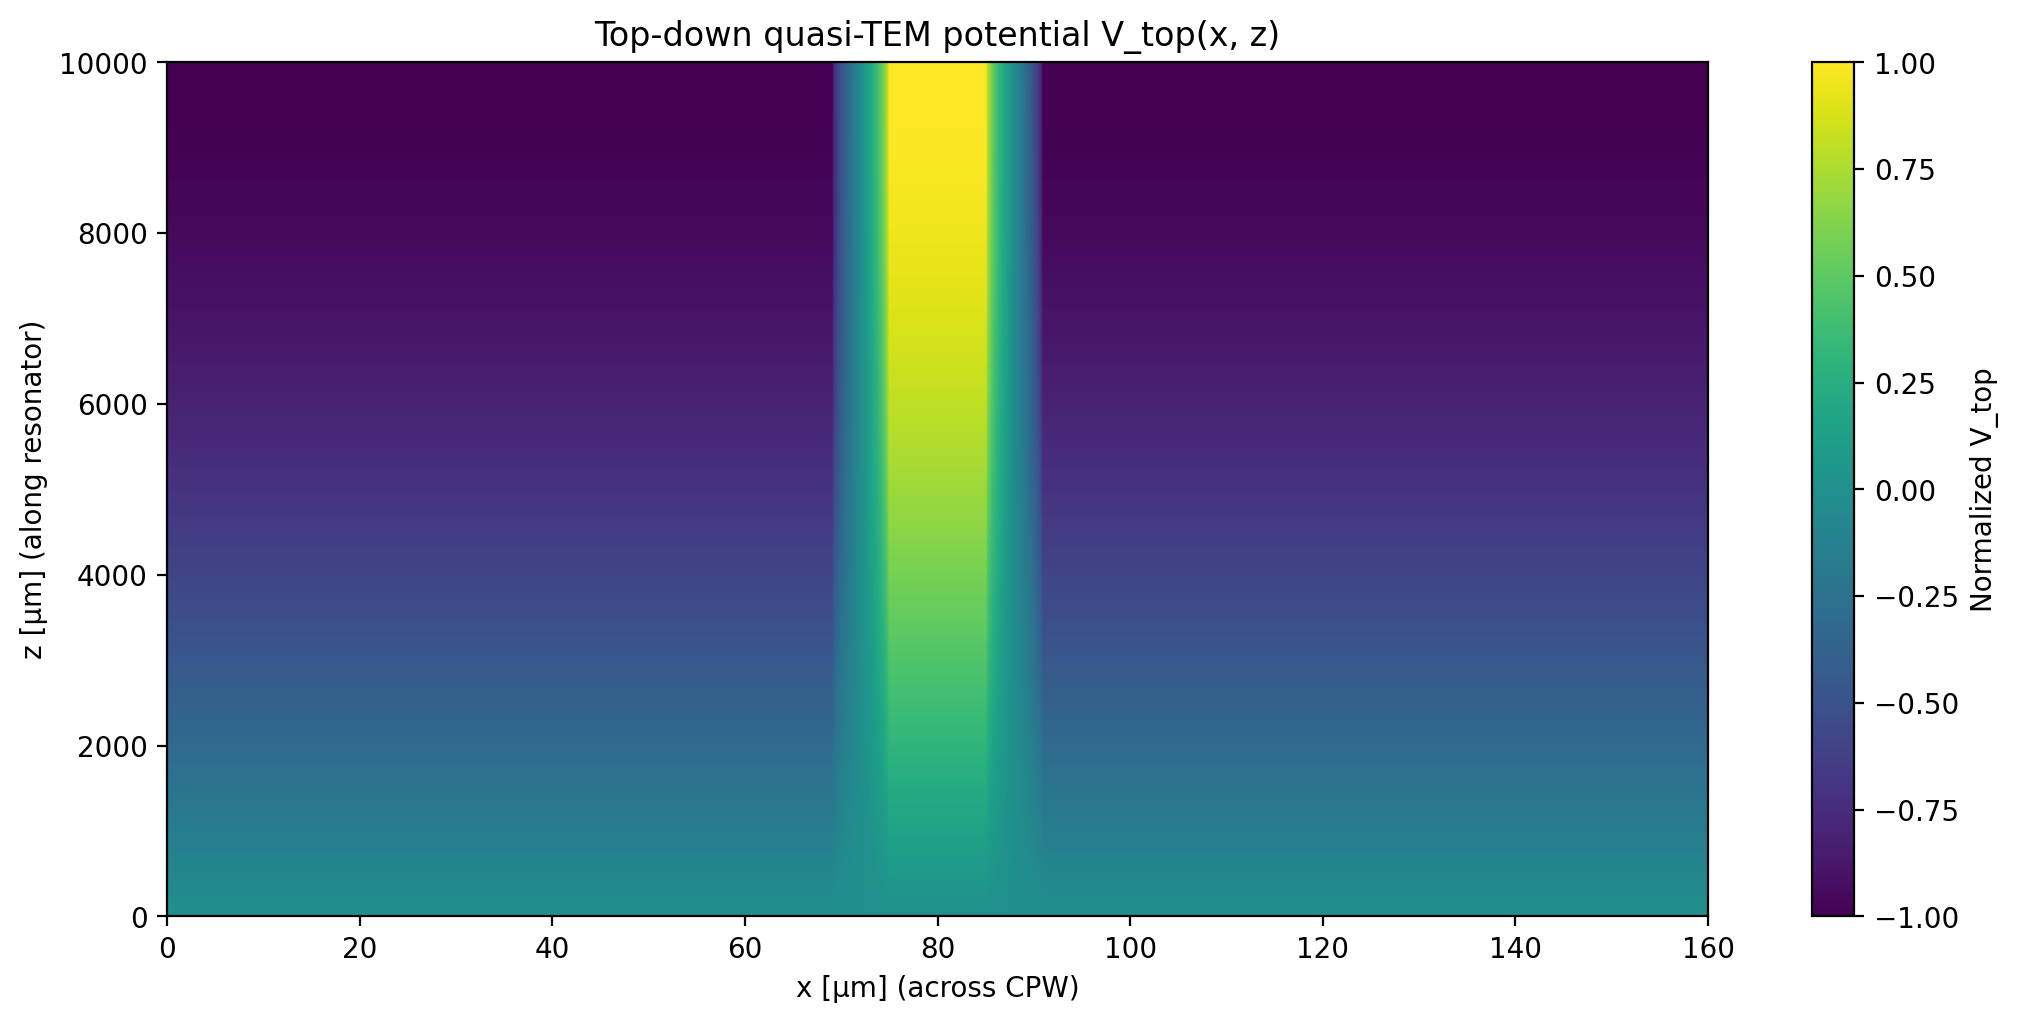

In [22]:
# @title 2D top-down heat map of V_top(x, z)
# @markdown Visualizes the quasi-TEM potential across the full CPW length.

import matplotlib.pyplot as plt

def plot_topdown_2d(
    x_um: np.ndarray,
    z_um: np.ndarray,
    V_top: np.ndarray,
    title: str = "Top-down quasi-TEM potential V_top(x, z)",
) -> None:
    """Plot a 2D heat map of V_top(x, z)."""
    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

    extent = [x_um[0], x_um[-1], z_um[0], z_um[-1]]
    im = ax.imshow(
        V_top,
        extent=extent,
        origin="lower",
        aspect="auto",
    )

    ax.set_xlabel("x [µm] (across CPW)")
    ax.set_ylabel("z [µm] (along resonator)")
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Normalized V_top")

    plt.show()


plot_topdown_2d(x_um_profile, z_um, V_top)


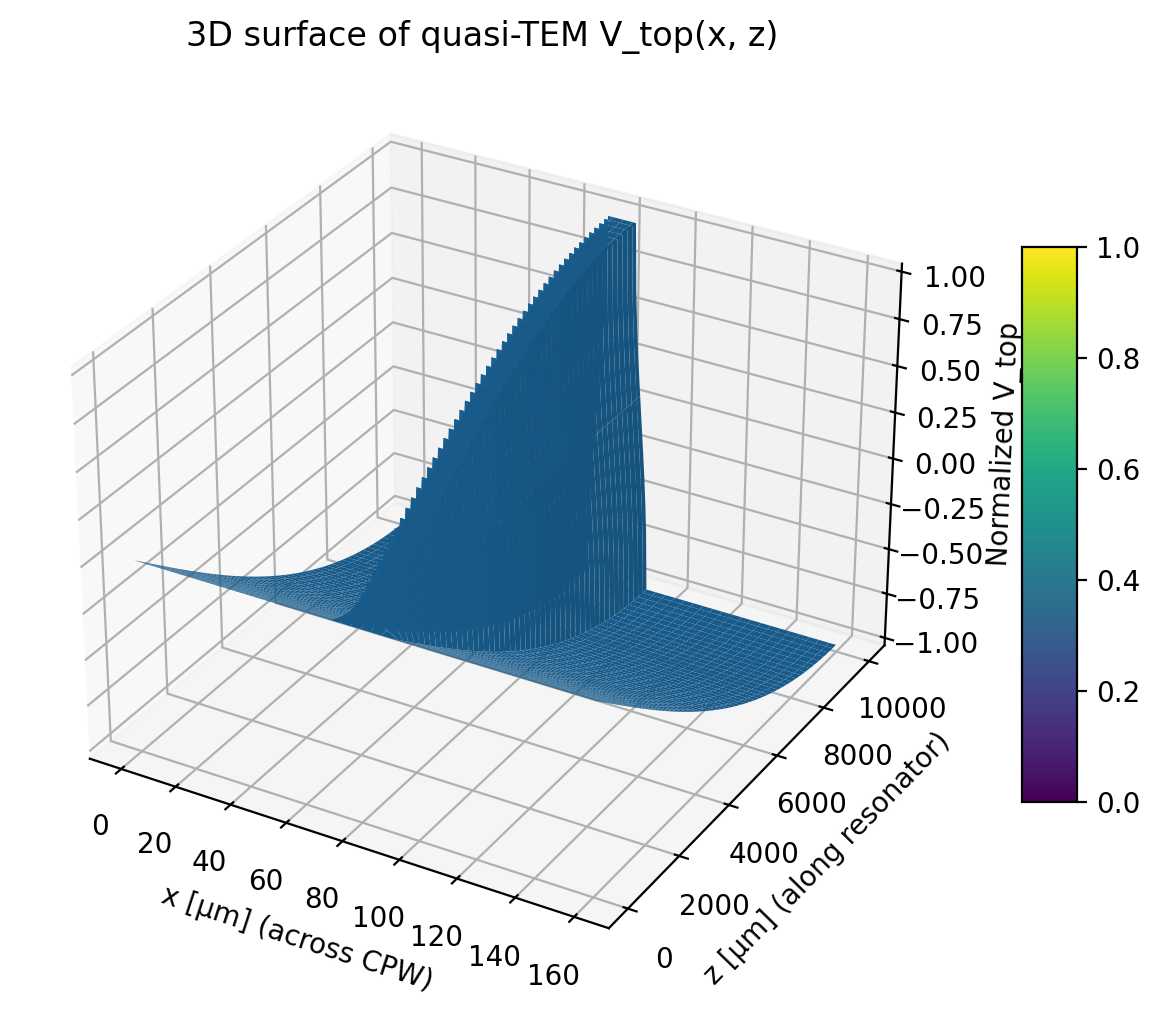

In [21]:
# @title 3D surface heat map of V_top(x, z)
# @markdown 3D representation of the top-down quasi-TEM potential.

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_topdown_3d(
    x_um: np.ndarray,
    z_um: np.ndarray,
    V_top: np.ndarray,
    downsample_x: int = 2,
    downsample_z: int = 2,
) -> None:
    """Plot a 3D surface of V_top(x, z).

    Args:
        x_um: Lateral coordinates [µm].
        z_um: Longitudinal coordinates [µm].
        V_top: 2D potential array (n_z, n_x).
        downsample_x: Downsample factor in x for plotting.
        downsample_z: Downsample factor in z for plotting.
    """
    x_ds = x_um[::downsample_x]
    z_ds = z_um[::downsample_z]
    V_ds = V_top[::downsample_z, ::downsample_x]

    Z_ds, X_ds = np.meshgrid(z_ds, x_ds, indexing="ij")

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        X_ds,
        Z_ds,
        V_ds,
        linewidth=0.0,
        antialiased=True,
    )
    ax.set_xlabel("x [µm] (across CPW)")
    ax.set_ylabel("z [µm] (along resonator)")
    ax.set_zlabel("Normalized V_top")
    ax.set_title("3D surface of quasi-TEM V_top(x, z)")
    fig.colorbar(surf, shrink=0.6, aspect=10)

    plt.show()


plot_topdown_3d(x_um_profile, z_um, V_top, downsample_x=2, downsample_z=2)
